In [1]:
import itertools as it
import pathlib

import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics as skl_metrics
from sklearn.linear_model import LinearRegression

import garpar as gp 

import pandas as pd 
import numpy as np

from libs import rankrev

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem .

In [2]:
skc.VERSION

'0.8.3'

In [3]:
DATA = pathlib.Path("data")

wfci = pd.read_csv(DATA / "datosFCI_sin_cedears.csv")
wfci.columns = wfci.columns.str.strip()
wfci["Fondo"] = [
    "Galicia", 
    "BNA",
    "MACRO",
    "Credicoop",
    "ICBC",
    "Comafi",
    "HSBC",
    "Patagonia",
    "Mariva",
    "Supervielle",
    "Santander",
    "Bs.As.",
    "Val.Allaria",
    "Val.Arpenta",
    "Val.Bull",
    "Val.SBS",
    "Val.Valiant"]
    

In [4]:
mervalf = gp.datasets.load_MERVAL(
    first="29-07-2021", last = "29-07-2022")
mervalf

Stocks,ALUA[⚖ 0.019231],BBAR[⚖ 0.019231],BYMA[⚖ 0.019231],CEPU[⚖ 0.019231],COME[⚖ 0.019231],CRES[⚖ 0.019231],CVH[⚖ 0.019231],EDN[⚖ 0.019231],GGAL[⚖ 0.019231],HARG[⚖ 0.019231],...,MOLA[⚖ 0.019231],MOLI[⚖ 0.019231],MORI[⚖ 0.019231],OEST[⚖ 0.019231],PATA[⚖ 0.019231],POLL[⚖ 0.019231],RIGO[⚖ 0.019231],SAMI[⚖ 0.019231],SEMI[⚖ 0.019231],TGLT[⚖ 0.019231]
Days,,,,,,,,,,,,,,,,,,,,,
2021-07-29,60.40,193.25,780.00,45.00,4.40,115.50,345.0,39.85,147.60,178.00,...,934.0,87.30,15.55,39.5,32.4,13.0,149.5,118.75,5.50,3.87
2021-07-30,60.30,188.80,780.00,44.65,4.33,112.25,339.0,39.00,142.55,176.00,...,894.0,85.40,15.45,39.5,32.2,15.0,149.0,117.75,5.45,3.80
2021-08-02,61.50,186.25,785.00,45.85,4.50,114.55,333.5,40.30,142.35,179.50,...,877.0,85.60,15.05,39.3,32.0,14.9,147.0,119.75,5.55,3.90
2021-08-03,61.10,185.00,790.00,44.65,4.50,111.70,332.0,41.00,145.60,179.25,...,957.0,88.00,15.20,39.0,32.0,14.9,147.0,120.00,5.55,3.80
2021-08-04,59.80,183.65,790.00,42.55,4.60,110.35,329.5,39.85,143.55,180.50,...,1030.0,88.70,15.00,36.5,32.1,14.8,147.0,122.00,5.40,3.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,144.75,251.85,204.50,104.10,15.75,164.90,686.0,75.60,214.35,194.50,...,2447.0,156.00,16.75,60.0,57.8,28.5,250.0,141.25,9.00,4.46
2022-07-26,139.50,257.75,205.50,106.30,15.30,174.90,700.5,75.90,214.50,201.00,...,2412.0,155.00,16.80,62.0,57.0,29.0,250.0,137.50,8.94,4.45
2022-07-27,146.50,274.85,222.00,117.55,16.25,183.50,707.5,79.00,225.65,210.00,...,2399.5,158.50,17.55,65.0,59.5,30.0,260.0,142.00,9.28,4.53


In [5]:
def asignw(nfondo):
    fondo = wfci[wfci["Fondo"]== nfondo]
    weights = []
    for stock in mervalf.stocks:
        try:
            w = float(fondo[stock].values[0].replace(",","."))
        except KeyError:
            w = 0.
        weights.append(w)

    nm = mervalf.copy(weights=weights,title=nfondo).scale_weights()
    return nm

def get_metrics(nfondo):
    mopt = asignw(nfondo).dprune().wprune().scale_weights()
    metrics = {
        "Fondo": nfondo,
       # "entropy": entropy,
        "Stock_number": len(mopt.stocks),
        "Beta_port": mopt.risk.pf_beta(),
        "variance_port": mopt.risk.pf_var(),
        "VaR_port": np.sum(mopt.risk.value() * mopt.weights),
        "Sharpe_Ratio": mopt.risk.sharpe(),
        "Treynor_Ratio": mopt.risk.treynor_ratio(),
        "Cross_Entropy": mopt.div.cross_entropy(),
        #"KeyZang_Entropy": mopt.div.ke_zang_entropy(),
        "Zheng_Entropy": mopt.div.zheng_entropy(),
        #"Delta_diversific": mopt.div.delta(),
        "Div_Ratio": mopt.div.ratio(),
        "CV_MC":(mopt.div.mrc() *  mopt.weights).std() / (mopt.div.mrc() *  mopt.weights).mean(),
        "PDI": mopt.div.pdi(n_components=5, random_state=100),
    }
    return metrics
    

In [6]:
translate = {"stocks_seleccionados": "Selected stocks"}

In [7]:
rows = []
for nfondo in wfci.Fondo:
    metrics = get_metrics(nfondo)
    rows.append(metrics)
metrics = pd.DataFrame(rows)
metrics.set_index("Fondo", inplace=True, drop=True)
metrics

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Fondo,,,,,,,,,,,
Galicia,27,1.673191,0.106095,0.040332,-3.237707,-0.642242,1.026304,2.648196,0.094987,1.352807,1.356961
BNA,19,1.305662,0.107886,0.040073,-2.825605,-0.726144,0.514198,2.588735,0.093679,0.963059,1.708972
MACRO,19,1.704964,0.112052,0.040180,-2.813989,-0.564210,0.778968,2.358540,0.092209,1.225660,1.689137
Credicoop,18,1.354701,0.102477,0.039187,-2.891776,-0.698101,0.454785,2.608311,0.096451,0.810086,1.673447
ICBC,26,1.468175,0.088988,0.038297,-3.360620,-0.696445,0.678679,2.814764,0.102112,1.055144,1.381591
Comafi,7,0.976238,0.119388,0.040135,-2.818415,-1.018025,0.192727,1.786995,0.081438,0.506193,3.650204
HSBC,24,1.876506,0.104736,0.039604,-3.210461,-0.564347,1.009999,2.572979,0.096354,1.240999,1.369945
Patagonia,16,0.920309,0.115454,0.040872,-2.812602,-1.060166,0.386546,2.441289,0.089836,0.925144,1.914891
Mariva,15,1.463561,0.111366,0.040206,-2.223565,-0.520673,0.729467,2.205304,0.096718,1.041671,1.936375


In [8]:
metrics.describe()

,Stock_number,Beta_port,variance_port,VaR_port,Sharpe_Ratio,Treynor_Ratio,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,16.411765,1.339938,0.110256,0.039950,-2.858527,-0.774210,0.567449,2.349503,0.093555,0.959161,1.951765
std,6.103880,0.338658,0.008403,0.000715,0.341308,0.239994,0.378853,0.271188,0.005564,0.264844,0.581681
min,7.000000,0.920309,0.088988,0.038297,-3.447793,-1.277967,0.065626,1.786995,0.081438,0.506193,1.356961
25%,11.000000,0.988322,0.104736,0.039446,-3.015587,-1.006628,0.295975,2.189832,0.091985,0.703042,1.689137
50%,18.000000,1.354701,0.110189,0.040135,-2.825605,-0.698101,0.454785,2.358540,0.093679,0.963059,1.768526
75%,19.000000,1.614809,0.117246,0.040332,-2.812602,-0.564347,0.778968,2.572979,0.096451,1.225660,2.073541
max,27.000000,1.914415,0.124626,0.040909,-2.223565,-0.400044,1.297474,2.814764,0.102112,1.352807,3.650204


In [9]:
metrics.skew(axis = 0, skipna = None, level = None, numeric_only = None)

Stock_number     0.054642
Beta_port        0.255880
variance_port   -0.659074
VaR_port        -0.773354
Sharpe_Ratio     0.207153
Treynor_Ratio   -0.459235
Cross_Entropy    0.511202
Zheng_Entropy   -0.343898
Div_Ratio       -0.372444
CV_MC           -0.065652
PDI              1.865355
dtype: float64

In [10]:
metrics.kurt(axis=0, skipna=True, level=None, numeric_only=None)

Stock_number    -0.751806
Beta_port       -1.258173
variance_port    1.314480
VaR_port         0.244370
Sharpe_Ratio     0.011920
Treynor_Ratio   -0.578919
Cross_Entropy   -0.821514
Zheng_Entropy   -0.359338
Div_Ratio        0.197386
CV_MC           -1.124959
PDI              3.972555
dtype: float64

In [11]:
objectives = [
    max, #     'stocks_seleccionados', coincide con definición mayor número de stocks
    min, #     'beta_portafolio', ver estaría bueno fuera cercana a 1 a màs o menos pronbunciada que el mercado. Ver RIM 
    min, #     'varianza_portafolio',
    min, #     'VaR_portafolio', es el valor promedio ponderado que asigna una probabilidad del 5% a tener pérdida, se busca lo más bajo posible para que pequeños movimientos no afecten  
    max, #     'Sharpe_Ratio', es el exceso de rendimiento sobre la tasa libre de riesgo en relación a la variabilidad, busco maximizar porque denominador debe hacerse más pequeño y numerador más grande 
    max, #     'Treynor_Ratio', mide el rendimiento en relación al Beta_i
    min, #     'Entropia_cruzada', mide el desorden al compararlo con una estrategia teórica de riski part equall
    max, #     'Entropia_Zheng', 
    max, #     'Ratio_diversific', mide la diversificación ganada por  mantener activos no correlacionados
    min, #     'CV_Contribuciones_marginales', si todos los activos tienen igual contribución marginal es un portfolio diversificado
    max, #     'Indice_diversific_port, si hay correlacióan alta el índice dará un valor bajo mientras que si no hay correlación el índice tenderá al valor N
]

dm = skc.mkdm(metrics.to_numpy(), objectives, alternatives=metrics.index, criteria=metrics.columns)

In [12]:
pipe_critic = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.CRITIC(),
    similarity.TOPSIS(),
)
pipe_critic

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='matrix']>), ('critic', <CRITIC [correlation='pearson', scale=True]>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [13]:
result = pipe_critic.evaluate(dm)
result

Alternatives,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,3,10,5,13,6,8,4,11,7,2,1,12,17,14,9,15,16


In [14]:
result.e_.similarity

array([0.56904331, 0.38747714, 0.48149374, 0.35020208, 0.4731049 ,
       0.40152968, 0.54975861, 0.38514102, 0.42065099, 0.57584093,
       0.60878389, 0.3630301 , 0.27850093, 0.34455722, 0.39538616,
       0.29779411, 0.29738423])

In [15]:
dm_critic = pipe_critic.transform(dm)

In [16]:
dm_critic.weights[1:]

Beta_port        0.107231
variance_port    0.088268
VaR_port         0.091406
Sharpe_Ratio     0.084879
Treynor_Ratio    0.102465
Cross_Entropy    0.084909
Zheng_Entropy    0.076027
Div_Ratio        0.091488
CV_MC            0.085032
PDI              0.105447
Name: Weights, dtype: float64

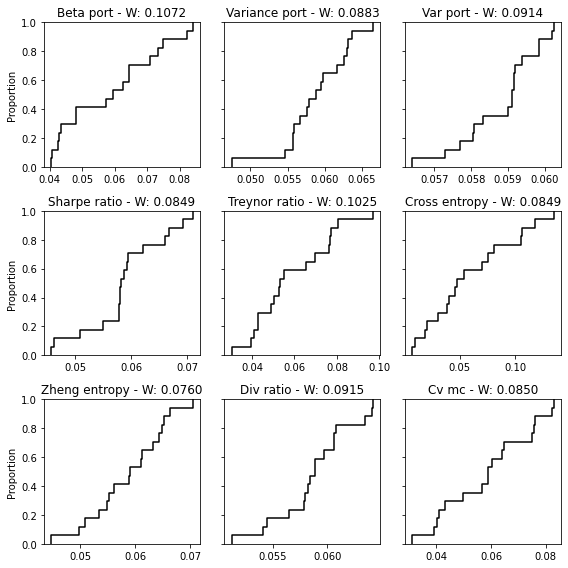

In [17]:
fig, axs = plt.subplots(3, 3, sharex=False, sharey=True)
fig.set_size_inches(8, 8)
axs = it.chain(*axs)
for crit, wt, ax  in zip(dm_critic.criteria[1:], dm_critic.weights[1:], axs):
    
    
    valc = dm_critic.criteria[crit]
    
    sns.ecdfplot(valc, ax=ax, color="k")
    
    ax.set_xlabel("")
    
    title = translate.get(crit, crit)
    title = title.replace("_", " ").capitalize()
    ax.set_title(f"{title} - W: {wt:.4f}")

fig.tight_layout()
plt.savefig("imgs/ogive_full.pdf", bbox_inches='tight')

In [18]:
pipe_entropy = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.EntropyWeighter(),
    similarity.TOPSIS(),
)
pipe_entropy

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='matrix']>), ('entropyweighter', <EntropyWeighter []>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [19]:
result_entropy = pipe_entropy.evaluate(dm)
result_entropy

Alternatives,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,3,8,5,9,7,14,4,11,6,2,1,10,13,12,16,15,17


In [20]:
result_entropy.e_.similarity

array([0.76198917, 0.37124859, 0.57259421, 0.32337427, 0.50560544,
       0.14621014, 0.74642165, 0.27594952, 0.52843299, 0.83242789,
       0.89378664, 0.31124793, 0.19051476, 0.25273161, 0.10986657,
       0.11903085, 0.08056393])

In [21]:
dm_entropy = pipe_entropy.transform(dm)

vmin=0.0003, vmax=0.4835, center=0.0590


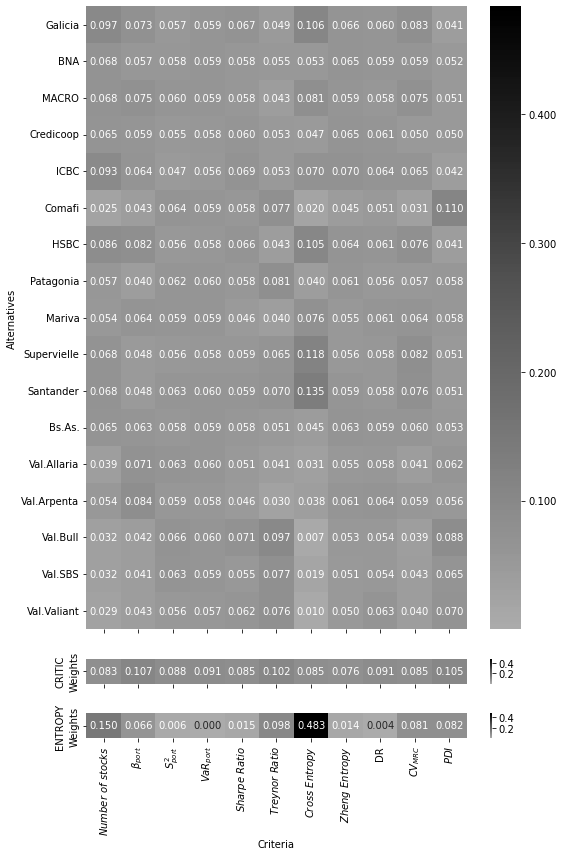

In [22]:
trans = [
     "$Number$ $of$ $stocks$",
     r"$\beta_{port}$", 
     "$S^2_{port}$", 
    "$VaR_{port}$", 
    "$Sharpe$ $Ratio$",
    "$Treynor$ $Ratio$",
    "$Cross$ $Entropy$",
    "$Zheng$ $Entropy$",
      "DR",
    "$CV_{MRC}$",
     "$PDI$",
]
dmttrans= dm_critic
dmt2trans = dm_entropy

fig, axs = plt.subplots(
    3, 1, figsize=(8,12), gridspec_kw={'height_ratios': [5, .2, .2]},sharex=True)

all_values = np.concatenate((dm_critic.matrix.to_numpy().flatten(), dm_critic.weights.to_numpy(), dm_entropy.weights.to_numpy()))
vmin, vmax, center = all_values.min(), all_values.max(), np.quantile(all_values, .5)


print(f"{vmin=:.4f}, {vmax=:.4f}, {center=:.4f}")

del all_values

dmttrans.plot.heatmap(ax=axs[0], cmap="Greys", vmin=vmin, vmax=vmax, center=center, fmt=".3f", cbar_kws={"format":"%.3f"})
dmttrans.plot.wheatmap(ax=axs[1], cmap="Greys", vmin=vmin, vmax=vmax, center=center, fmt=".3f")
dmt2trans.plot.wheatmap(ax=axs[2], cmap="Greys", vmin=vmin, vmax=vmax, center=center, fmt=".3f")

axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("CRITIC")
axs[2].set_ylabel("ENTROPY")
axs[2].set_xticklabels(trans)


fig.tight_layout()
plt.savefig("imgs/mapanormal.pdf",bbox_inches='tight');


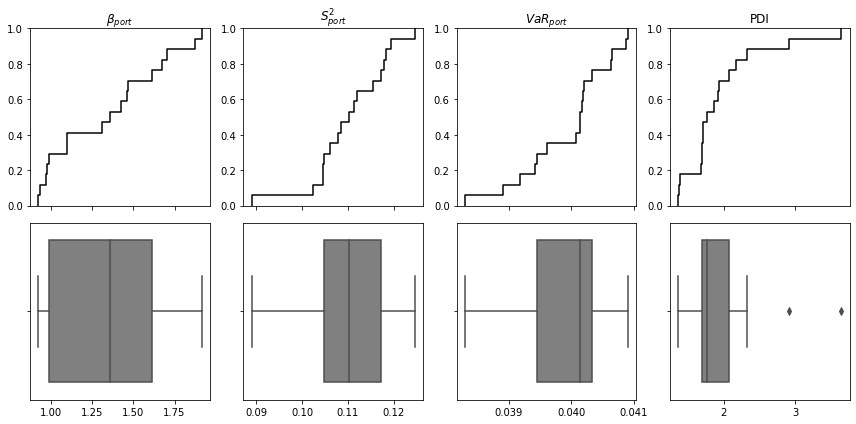

In [23]:
trans = {
    'Beta_port': r"$\beta_{port}$", 
    'variance_port': "$S^2_{port}$", 
    'VaR_port': "$VaR_{port}$", 
    'PDI': "PDI",
}

masym = dm_critic[list(trans)]

fig, axs = plt.subplots(2, len(trans), sharex=False, sharey=False)
fig.set_size_inches(3 * len(trans), 6)

for crit, ax  in zip(masym.criteria, axs.T):
    
    valo = dm.criteria[crit]
    valc = dm_critic.criteria[crit]
    
    sns.ecdfplot(x=valo, ax=ax[0], color="k")
    sns.boxplot(x=valo, ax=ax[1], color="grey")

    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[0].set_xticklabels([])
    
    title = trans[crit]
    ax[0].set_title(title)
    
    ax[1].set_xlabel("")
    
    # comparimos los ejes
    ax[0].get_shared_x_axes().join(*ax)
    
fig.tight_layout()
plt.savefig("imgs/ogivesinnormalizar.pdf", bbox_inches='tight')

In [24]:
pipe_critic

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='matrix']>), ('critic', <CRITIC [correlation='pearson', scale=True]>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [25]:
rt1 = rankrev.RankReversalTest1(pipe_critic, repeats=10, allow_missing_alternatives=True)
rt1

<RankReversalTest1 <SKCPipeline [steps=[('negateminimize', <NegateMin...> repeats=10,  allow_missing_alternatives=True last_diff_strategy=<function median at 0x7f8d7811e670> seed=None>

In [26]:
rcmp = rt1.evaluate(dm)
rcmp

<RanksComparator [ranks=['Original', 'M.Supervielle_1', 'M.Galicia_1', 'M.HSBC_1', 'M.MACRO_1', 'M.ICBC_1', 'M.Mariva_1', 'M.Comafi_1', 'M.Val.Bull_1', 'M.BNA_1', 'M.Patagonia_1', 'M.Bs.As._1', 'M.Credicoop_1', 'M.Val.Arpenta_1', 'M.Val.SBS_1', 'M.Val.Valiant_1', 'M.Val.Allaria_1', 'M.Supervielle_2', 'M.Galicia_2', 'M.HSBC_2', 'M.MACRO_2', 'M.ICBC_2', 'M.Mariva_2', 'M.Comafi_2', 'M.Val.Bull_2', 'M.BNA_2', 'M.Patagonia_2', 'M.Bs.As._2', 'M.Credicoop_2', 'M.Val.Arpenta_2', 'M.Val.SBS_2', 'M.Val.Valiant_2', 'M.Val.Allaria_2', 'M.Supervielle_3', 'M.Galicia_3', 'M.HSBC_3', 'M.MACRO_3', 'M.ICBC_3', 'M.Mariva_3', 'M.Comafi_3', 'M.Val.Bull_3', 'M.BNA_3', 'M.Patagonia_3', 'M.Bs.As._3', 'M.Credicoop_3', 'M.Val.Arpenta_3', 'M.Val.SBS_3', 'M.Val.Valiant_3', 'M.Val.Allaria_3', 'M.Supervielle_4', 'M.Galicia_4', 'M.HSBC_4', 'M.MACRO_4', 'M.ICBC_4', 'M.Mariva_4', 'M.Comafi_4', 'M.Val.Bull_4', 'M.BNA_4', 'M.Patagonia_4', 'M.Bs.As._4', 'M.Credicoop_4', 'M.Val.Arpenta_4', 'M.Val.SBS_4', 'M.Val.Valiant_4'

In [27]:
rrdf = rcmp.to_dataframe().T
sort = np.argsort(rcmp.to_dataframe().T.mean()).to_numpy()
columns = rcmp.to_dataframe().T.columns
order = columns[sort]


rows = []
for r in np.arange(1, 18):
    row = {}
    for a in order:
        alt = rrdf[a].to_numpy()
        row[a] = (alt == r).sum() / len(alt)
    rows.append(row)
        
    
rrdf = pd.DataFrame(rows, index=np.arange(1,18))
rrdf.columns.name = "Stoks"
rrdf.index.name = "Ranking"

with pd.option_context('display.precision', 3):
    display(rrdf)

Stoks,Santander,Supervielle,Galicia,HSBC,MACRO,ICBC,Mariva,Comafi,Val.Bull,BNA,Patagonia,Bs.As.,Credicoop,Val.Arpenta,Val.Valiant,Val.SBS,Val.Allaria
Ranking,,,,,,,,,,,,,,,,,
1,1.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.0,0.82,0.168,0.006,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.0,0.18,0.807,0.012,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.0,0.00,0.025,0.969,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.0,0.00,0.000,0.012,0.876,0.081,0.025,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.0,0.00,0.000,0.000,0.118,0.876,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.0,0.00,0.000,0.000,0.006,0.043,0.783,0.012,0.025,0.043,0.050,0.000,0.012,0.025,0.000,0.000,0.000
8,0.0,0.00,0.000,0.000,0.000,0.000,0.174,0.665,0.031,0.068,0.006,0.000,0.019,0.019,0.019,0.000,0.000
9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.267,0.590,0.106,0.025,0.000,0.006,0.006,0.000,0.000,0.000


In [28]:
(dm_critic.matrix * dm_critic.weights).T.describe()

Alternatives,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.006171,0.005286,0.005643,0.005124,0.005670,0.004961,0.006034,0.005210,0.005246,0.005885,0.006092,0.005224,0.004783,0.005058,0.005163,0.004678,0.004680
std,0.001552,0.000446,0.001073,0.000644,0.001010,0.002837,0.001622,0.001224,0.001004,0.001577,0.001902,0.000681,0.001491,0.001612,0.002710,0.001777,0.002045
min,0.004312,0.004526,0.004392,0.004003,0.004191,0.001696,0.004354,0.003402,0.003884,0.004269,0.004483,0.003847,0.002605,0.003114,0.000578,0.001584,0.000817
25%,0.005020,0.004979,0.005096,0.004895,0.005256,0.003021,0.004915,0.004699,0.004326,0.005073,0.005230,0.005018,0.003830,0.004189,0.003690,0.003769,0.003599
50%,0.005464,0.005389,0.005368,0.005274,0.005502,0.004685,0.005543,0.004913,0.005411,0.005346,0.005471,0.005181,0.004319,0.005001,0.004982,0.004659,0.004922
75%,0.007466,0.005537,0.006017,0.005390,0.005924,0.005512,0.006799,0.005469,0.005859,0.006165,0.006045,0.005398,0.005521,0.005586,0.005946,0.005477,0.005534
max,0.009033,0.006146,0.008026,0.006377,0.007721,0.011600,0.008890,0.008254,0.006890,0.010027,0.011420,0.006713,0.007602,0.009012,0.009949,0.007843,0.007837


In [54]:
ax.get_yticks()

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

/tmp/ipykernel_12045/216022884.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks().astype(int),  fontdict={'fontsize': 12})


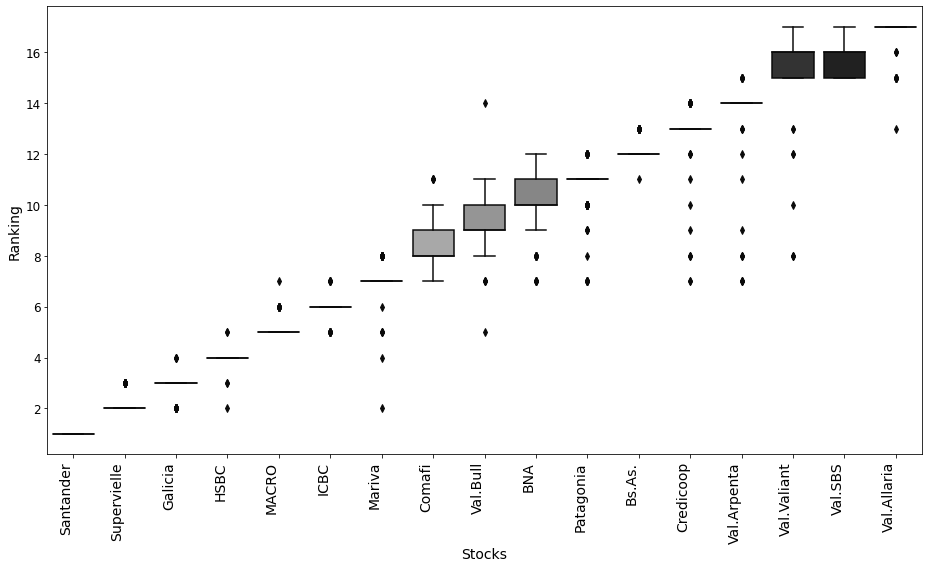

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(13,8)
sns.boxplot(data=rcmp.to_dataframe().T[order], palette="Greys")

ax.set_ylabel("Ranking", fontdict={'fontsize': 14})
ax.set_yticklabels(ax.get_yticks().astype(int),  fontdict={'fontsize': 12})

ax.set_xlabel("Stocks", fontdict={'fontsize': 14})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontdict={'fontsize': 14})

fig.tight_layout()
plt.savefig("imgs/CajasordenamientoT1.pdf", bbox_inches='tight')

In [46]:
ax.set_xlabel?

Signature: ax.set_xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)
Docstring:
Set the label for the x-axis.

Parameters
----------
xlabel : str
    The label text.

labelpad : float, default: :rc:`axes.labelpad`
    Spacing in points from the axes bounding box including ticks
    and tick labels.  If None, the previous value is left as is.

loc : {'left', 'center', 'right'}, default: :rc:`xaxis.labellocation`
    The label position. This is a high-level alternative for passing
    parameters *x* and *horizontalalignment*.

Other Parameters
----------------
**kwargs : `.Text` properties
    `.Text` properties control the appearance of the label.

See Also
--------
text : Documents the properties supported by `.Text`.
File:      ~/proyectos/mcda_div_metrics/lib/python3.9/site-packages/matplotlib/axes/_base.py
Type:      method
